In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import visualization
from utils.simulations import *
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
folder_path = './dataset/Simulations_6_indep/'  # change to your folder path
# file_names = os.listdir(folder_path)
# results_kmdist = []
# results_logrank = []
# # Display the file names
# for name in file_names:
#     if 'results_log_rank' in name:
#         print(name)
#         results_logrank.append(pd.read_csv(folder_path + name,index_col=0))
#     if 'results_survival_km_distance' in name:
#         print(name)
#         results_kmdist.append(pd.read_csv(folder_path + name,index_col=0))
# results_kmdist = pd.concat(results_kmdist)
# results_kmdist = results_kmdist.sort_values(by='XP_num')
# results_logrank = pd.concat(results_logrank)
# results_logrank = results_logrank.sort_values(by='XP_num')

In [3]:
# folder_path = './dataset/Simulations_4/'  # change to your folder path
results_kmdist = pd.read_csv(folder_path + 'results_survival_km_distance_n_samples_600_n_features_bytype_6.csv', index_col=0)
results_kmdist = results_kmdist.sort_values(by='XP_num')

In [4]:
# results_ext = pd.concat(results, ignore_index=True)
results_kmdist_ext = results_kmdist.copy(deep=True)
# results_logrank_ext = results_logrank.copy(deep=True)
treat_effects = np.unique(results_kmdist_ext.H0_coef.values)
# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-VAE"]
# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise"]

In [5]:
for col in results_kmdist_ext.columns:
    results_kmdist_ext[col] = np.float64(results_kmdist_ext[col].values)

# for col in results_logrank_ext.columns:
#     results_logrank_ext[col] = np.float64(results_logrank_ext[col].values)

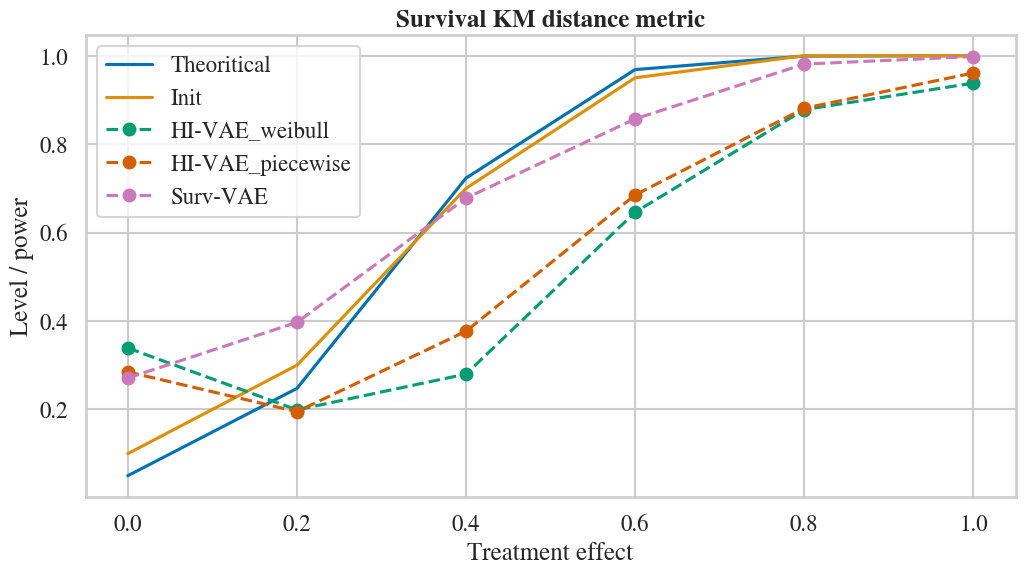

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))
ax.plot(treat_effects, np.array(power_theo), label = "Theoritical")

results_kmdist_ext["reject_H0_init"] = results_kmdist_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
ax.plot(treat_effects, power_init, '-', label = "Init")

custom_palette = ['deepskyblue','darkblue','orange', 'red']
for i, generator_name in enumerate(generators_sel):
    results_kmdist_ext["reject_H0_gen_" + generator_name] = results_kmdist_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

plt.xlabel("Treatment effect")
plt.ylabel("Level / power")
plt.title("Survival KM distance metric", fontweight='semibold')
plt.legend()
plt.show()
# plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

### Visualize only best generated control dataset for each MC experiment

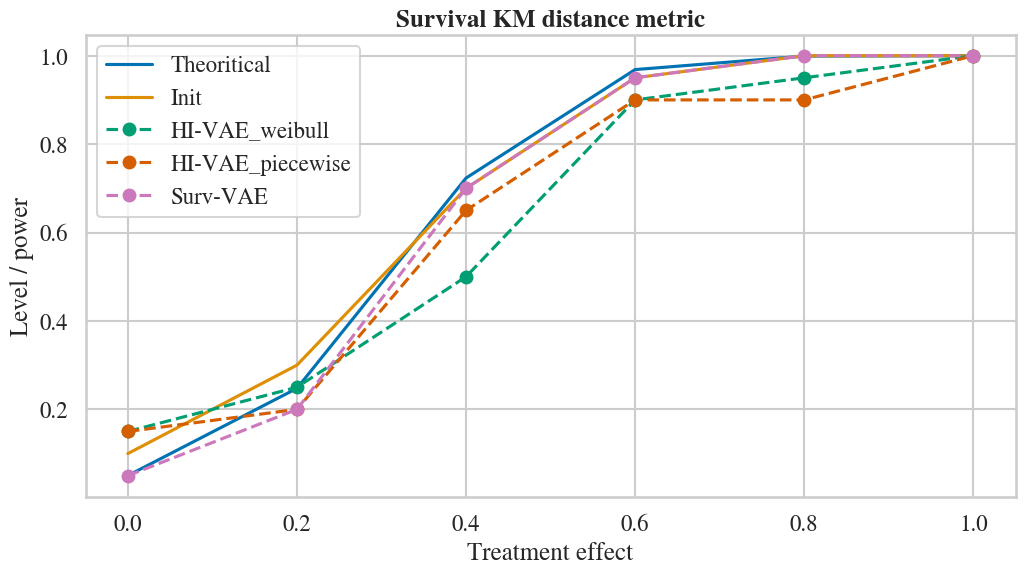

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))
ax.plot(treat_effects, np.array(power_theo), label = "Theoritical")

results_kmdist_ext["reject_H0_init"] = results_kmdist_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
ax.plot(treat_effects, power_init, '-', label = "Init")

custom_palette = ['deepskyblue','darkblue','orange', 'red']
XP_num = np.unique(results_kmdist_ext["XP_num"].values)

for generator_name in generators_sel:
    results_MC_best_list = []
    for m in XP_num:
        results_MC = results_kmdist_ext[results_kmdist_ext["XP_num"] == m]
        best_metric = np.min(results_MC["Survival curves distance_" + generator_name].values)
        results_MC_best = results_MC[results_MC["Survival curves distance_" + generator_name] == best_metric].copy(deep=True)
        results_MC_best["reject_H0_gen_" + generator_name] = results_MC_best['log_pvalue_' + generator_name] > -np.log(0.05)
        results_MC_best_list.append(results_MC_best)
    power_gen = pd.concat(results_MC_best_list).groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

# for i, generator_name in enumerate(generators_sel):
#     results_kmdist_ext["reject_H0_gen_" + generator_name] = results_kmdist_ext['log_pvalue_' + generator_name] > -np.log(0.05)
#     power_gen = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
#     ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

plt.xlabel("Treatment effect")
plt.ylabel("Level / power")
plt.title("Survival KM distance metric", fontweight='semibold')
plt.legend()
plt.show()
# plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

In [8]:
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))

# results_logrank_ext["reject_H0_init"] = results_logrank_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby(["XP_num", "H0_coef"]).mean().reset_index()
power_init_sel = power_init[["H0_coef"]]
power_init_sel["log_pvalue"] = power_init["log_pvalue_init"]
power_init_sel["Method"] = "Init"
power_gen_df = pd.DataFrame()
for i, generator_name in enumerate(generators_sel):
    # results_logrank_ext["reject_H0_gen_" + generator_name] = results_logrank_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_kmdist_ext.groupby(["XP_num", "H0_coef"]).mean().reset_index()
    power_gen_sel = power_gen[["H0_coef"]]
    power_gen_sel["log_pvalue"] = power_gen["log_pvalue_" + generator_name]
    power_gen_sel["Method"] = generator_name
    power_gen_df = pd.concat([power_gen_df, power_gen_sel])
power_df = pd.concat([power_init_sel, power_gen_df])

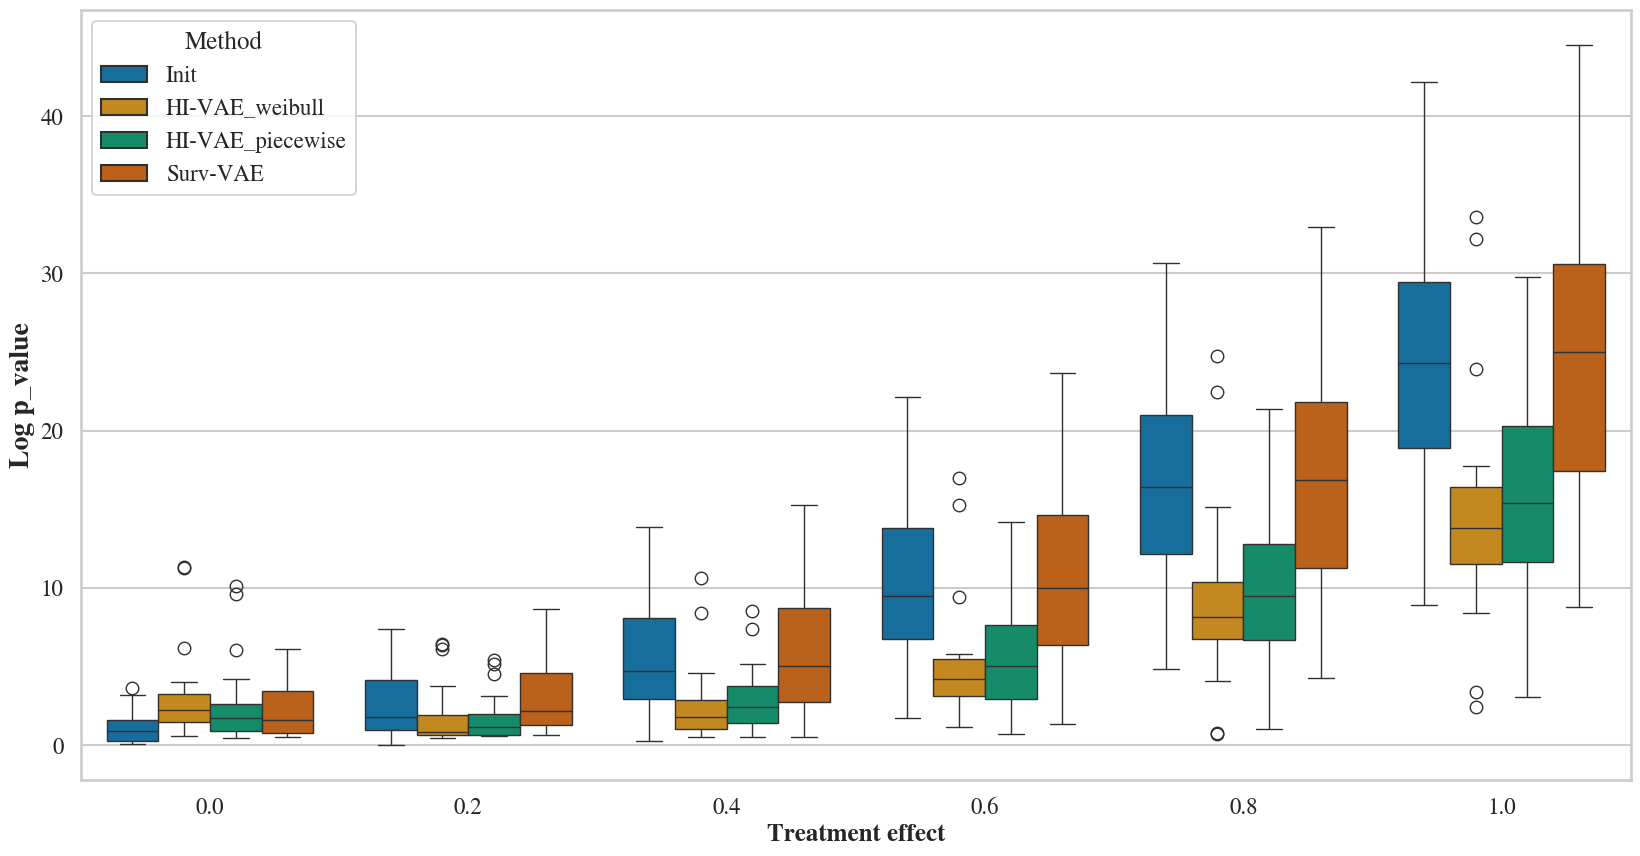

In [9]:
plt.figure(figsize=(20, 10))
sns.boxplot(x='H0_coef', y='log_pvalue', hue="Method", data=power_df)
# plt.ylim(-0.5, 1.5)
plt.xticks(ticks=np.arange(len(treat_effects)), labels=[str(int(te * 100) / 100) for te in treat_effects])
plt.xlabel('Treatment effect', fontweight="semibold")
plt.ylabel("Log p_value", fontsize=20, fontweight="semibold")
plt.show()

In [10]:
def visualize_synthcity_metric_res(results, metrics, title):
    num_metrics = len(metrics)
    n_learners = len(generators_sel)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics * n_learners, 10))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[i]
        metric_df = pd.DataFrame()
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results.shape[0], 
                                                            results[metric_name + "_" + generator_name]]).T,
                                                            columns=['generator', metric_name])])
        metric_df[metric_name] = np.float64(metric_df[metric_name].values)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                    linewidth = 3, saturation = 1, palette = 'colorblind', 
                    width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
        ax.set_xlabel('')
        ax.set_ylabel(metric_name, fontsize=30, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if opt == "max":
            ax.legend(title='Maximize \u2191', title_fontsize=15)
        else:
            ax.legend(title='Minimize \u2193', title_fontsize=15)
    plt.tight_layout(pad=3)
    fig.suptitle(title, fontsize=35, fontweight='semibold')

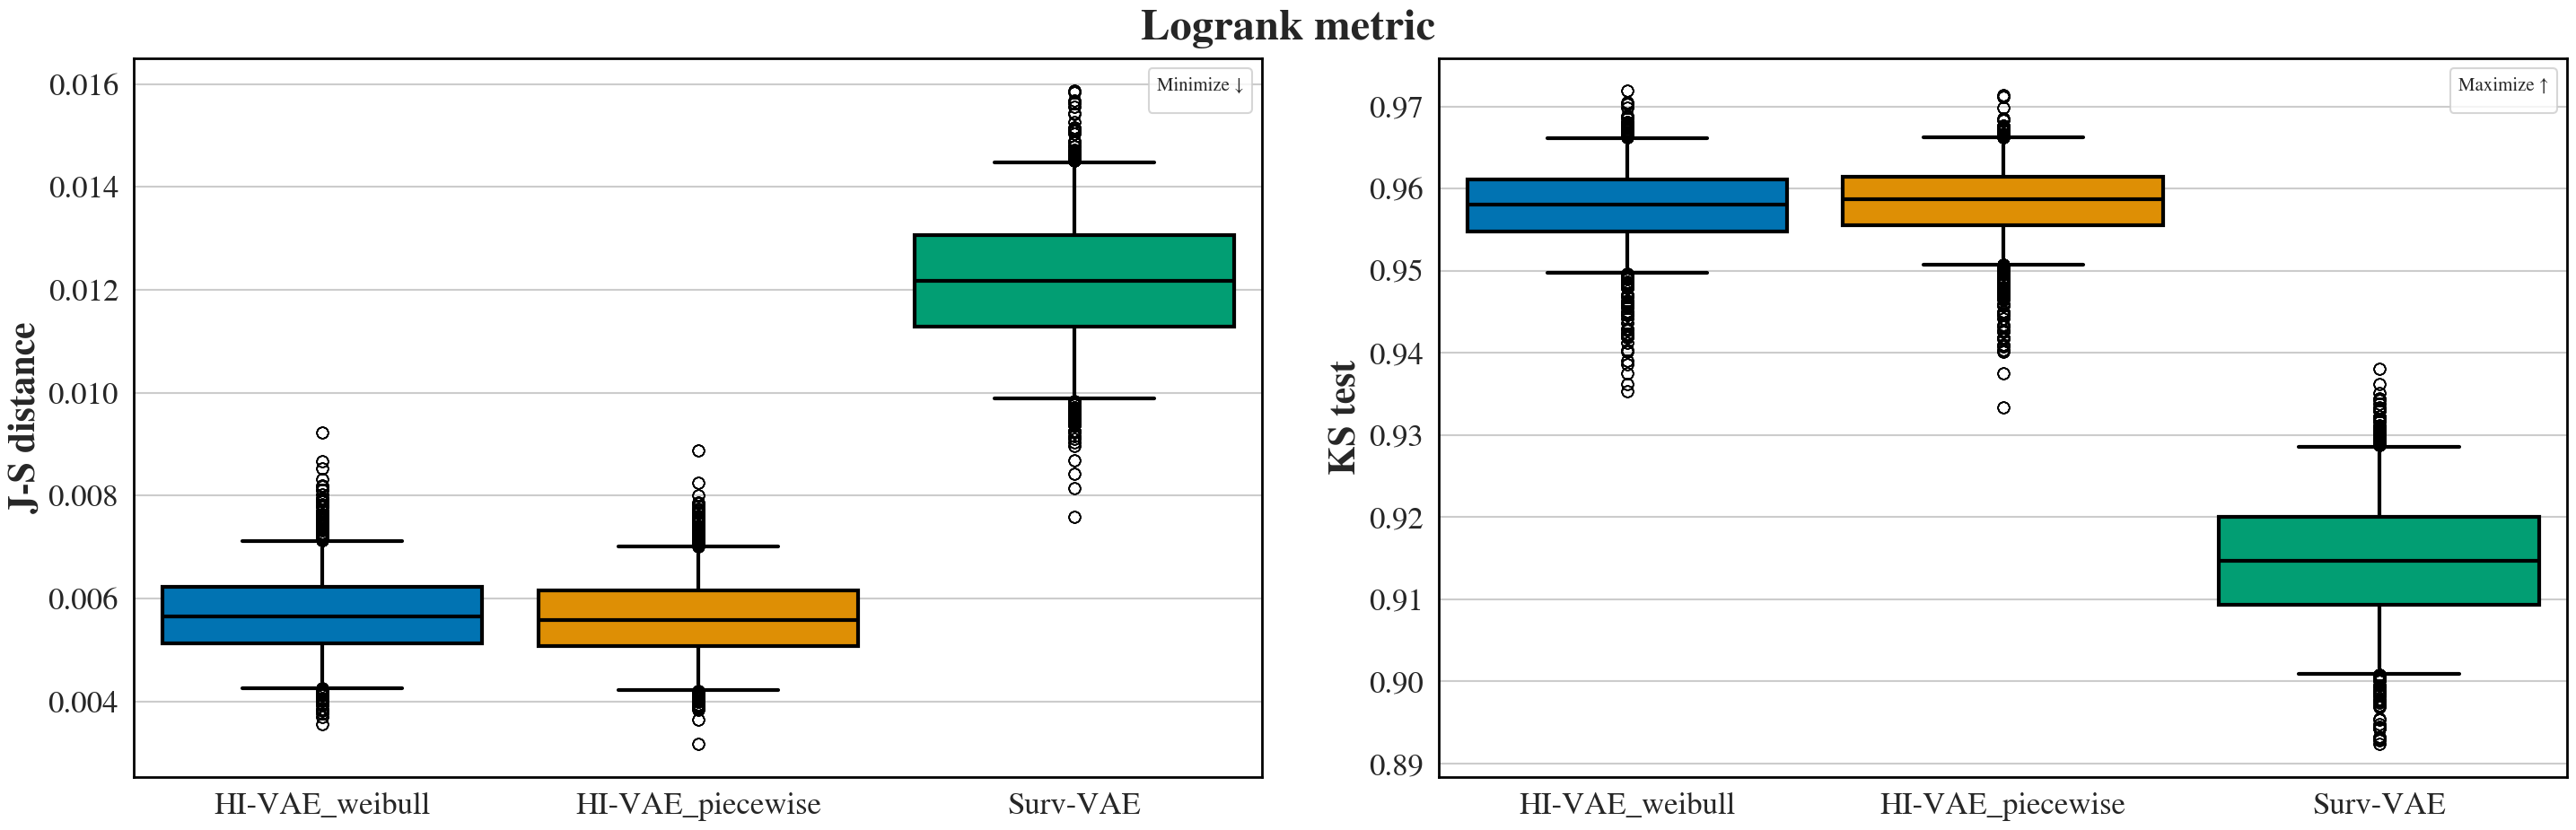

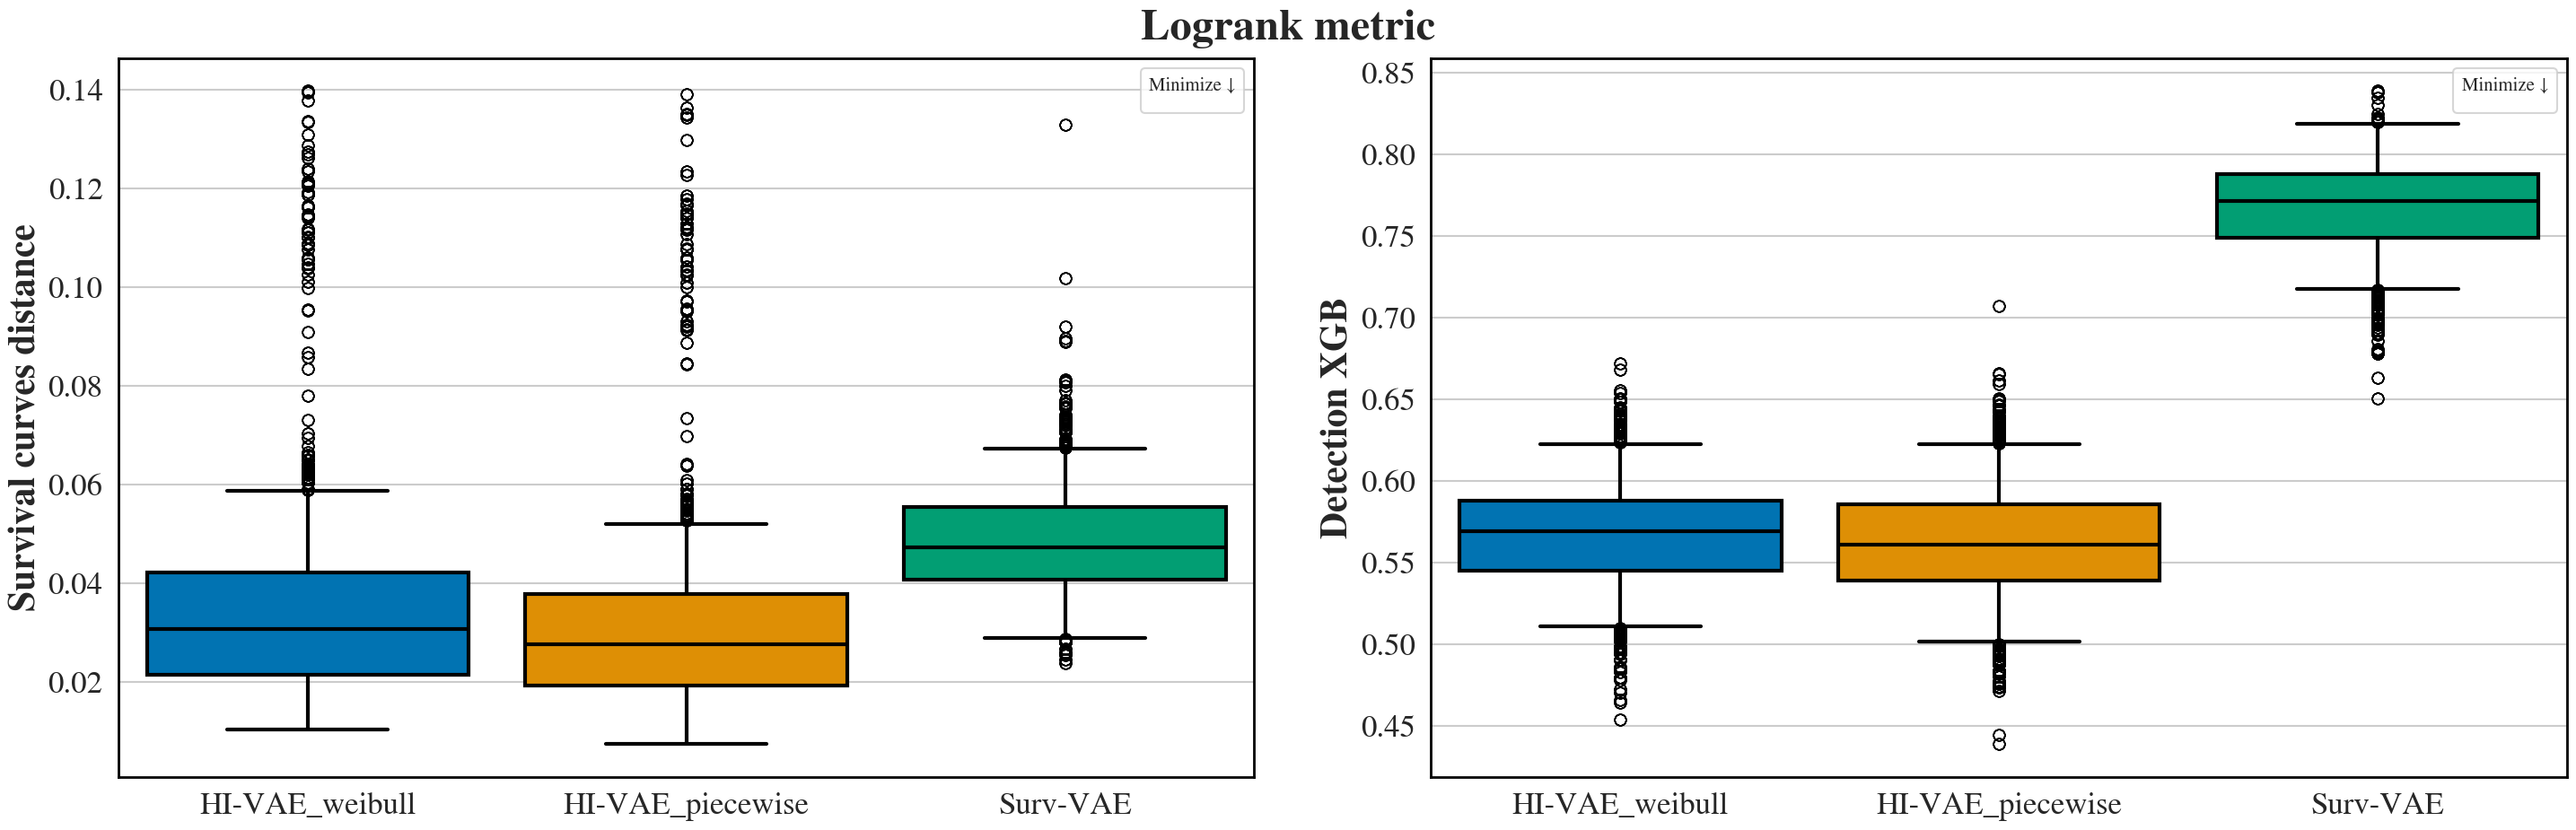

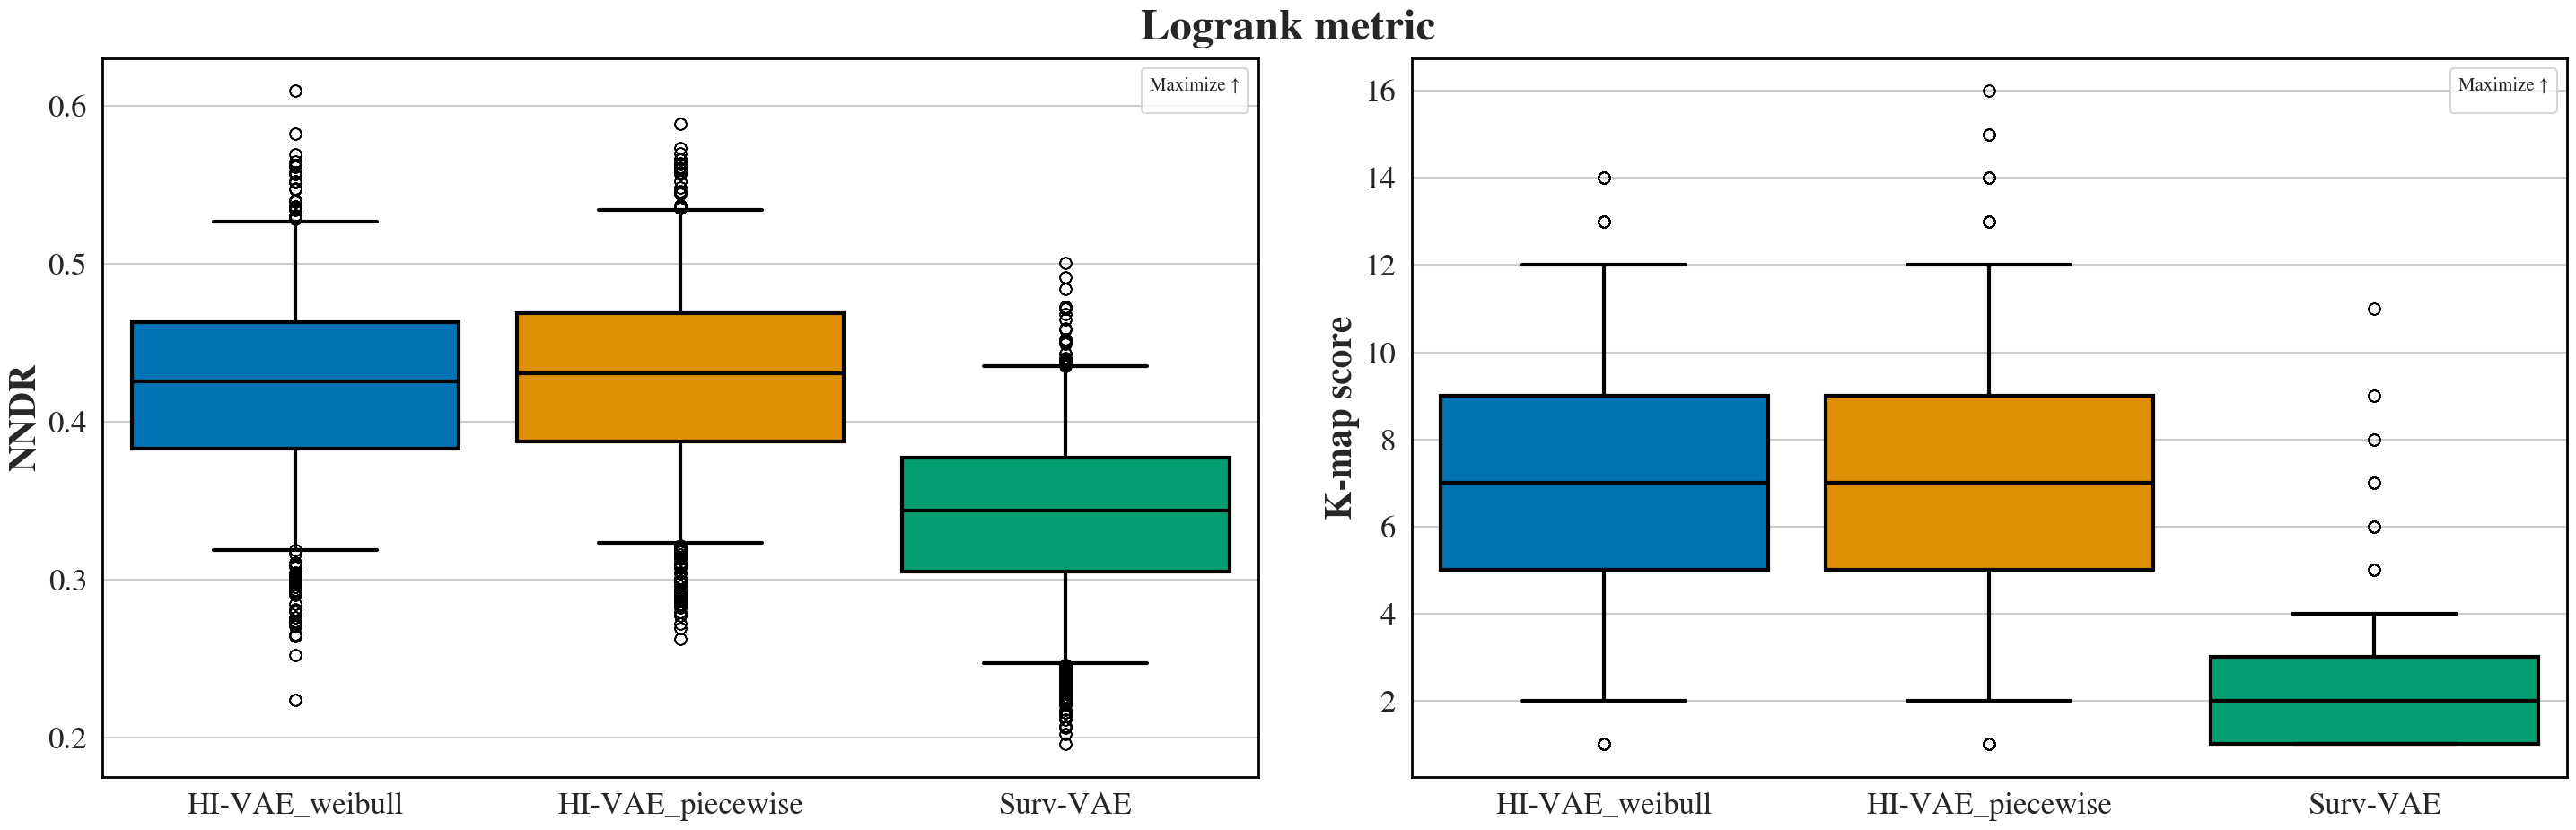

In [11]:
#### SYNTHCITY METRICS 
for metrics in [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]:
    visualize_synthcity_metric_res(results_kmdist, metrics, 'Logrank metric')

### Visualize only best generated control dataset for each MC experiment

In [12]:
def visualize_synthcity_metric_res_ext(results, metrics, title):
    num_metrics = len(metrics)
    n_learners = len(generators_sel)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics * n_learners, 10))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[i]
        metric_df = pd.DataFrame()
        XP_num = np.unique(results["XP_num"].values)
        for m in XP_num:
            results_MC = results[results["XP_num"] == m]
            for generator_name in generators_sel:
                best_metric = np.min(results_MC["Survival curves distance_" + generator_name].values)
                results_MC_best = results_MC[results_MC["Survival curves distance_" + generator_name] == best_metric]
                metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results_MC_best.shape[0], 
                                                                results_MC_best[metric_name + "_" + generator_name]]).T,
                                                                columns=['generator', metric_name])])
        metric_df[metric_name] = np.float64(metric_df[metric_name].values)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                    linewidth = 3, saturation = 1, palette = 'colorblind', 
                    width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
        ax.set_xlabel('')
        ax.set_ylabel(metric_name, fontsize=30, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if opt == "max":
            ax.legend(title='Maximize \u2191', title_fontsize=15)
        else:
            ax.legend(title='Minimize \u2193', title_fontsize=15)
    plt.tight_layout(pad=3)
    fig.suptitle(title, fontsize=35, fontweight='semibold')

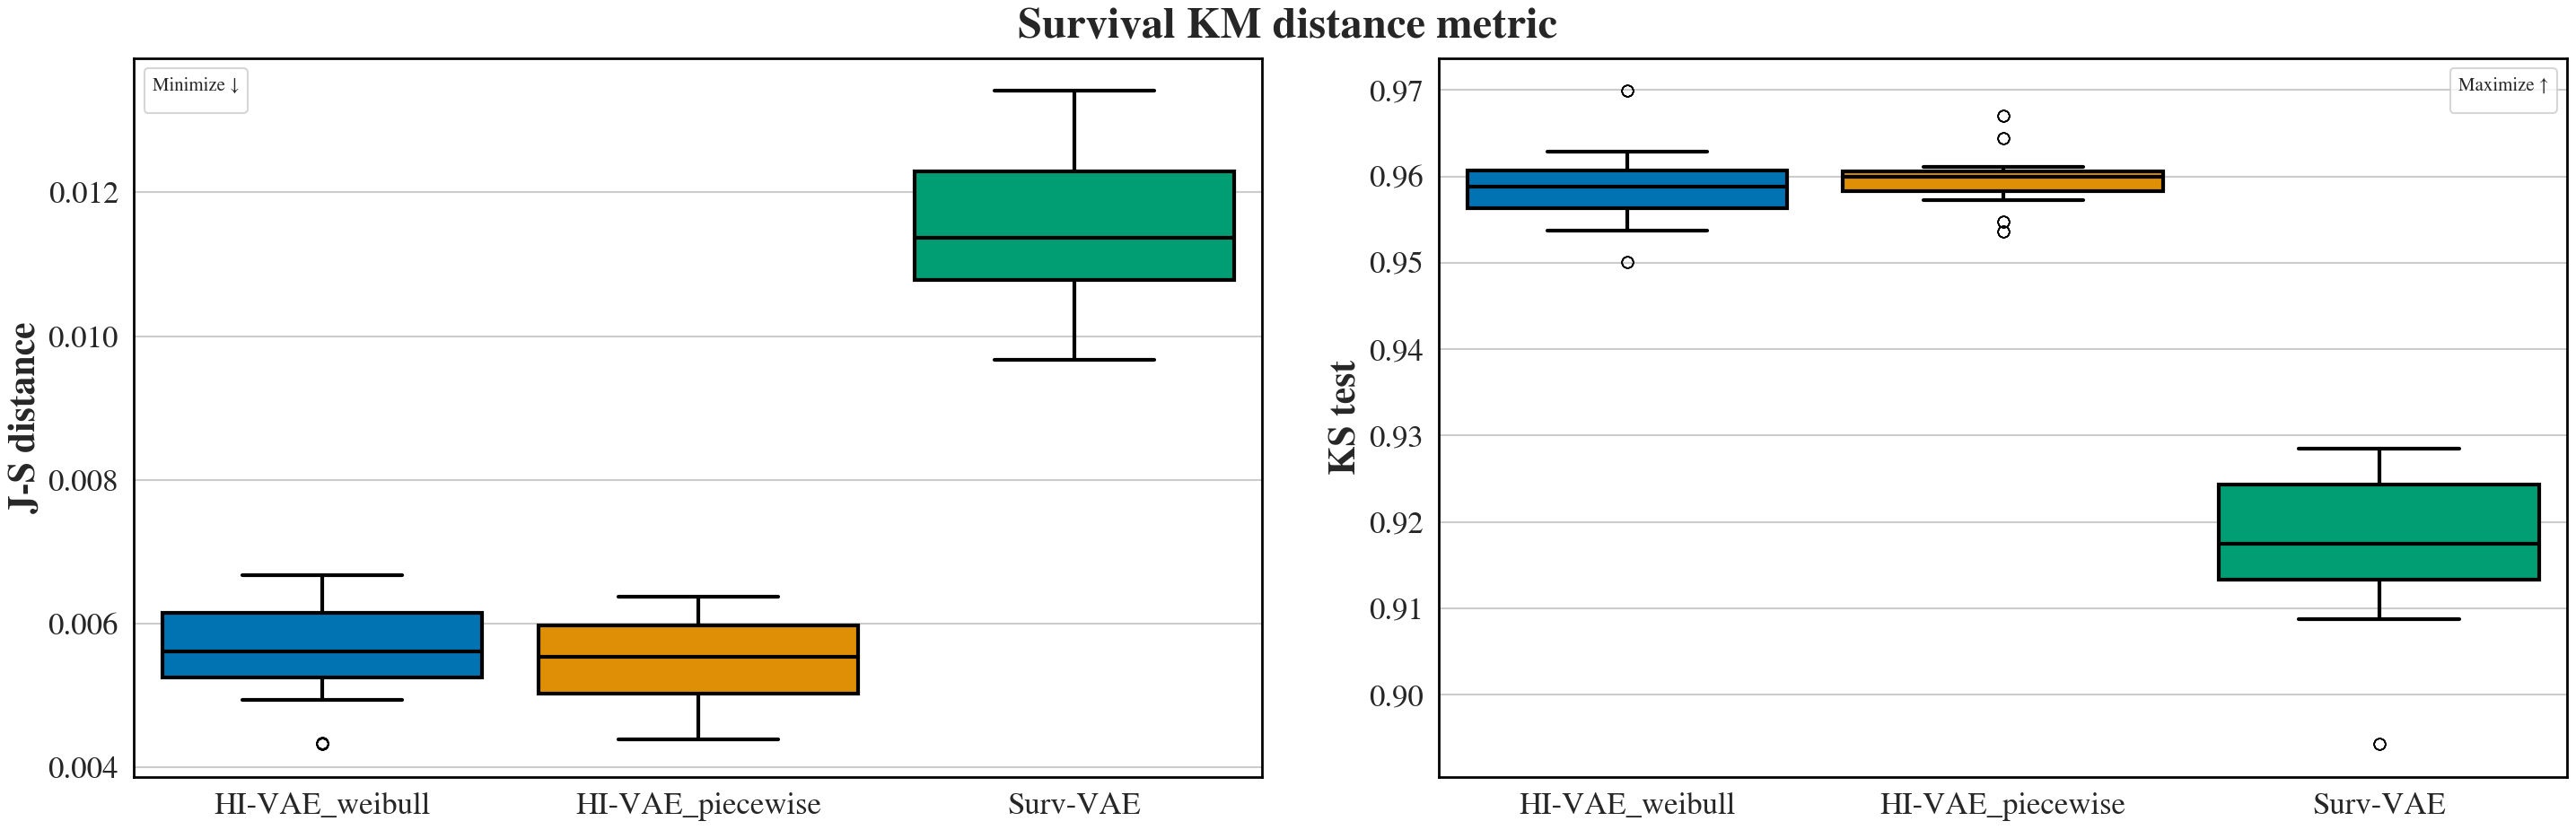

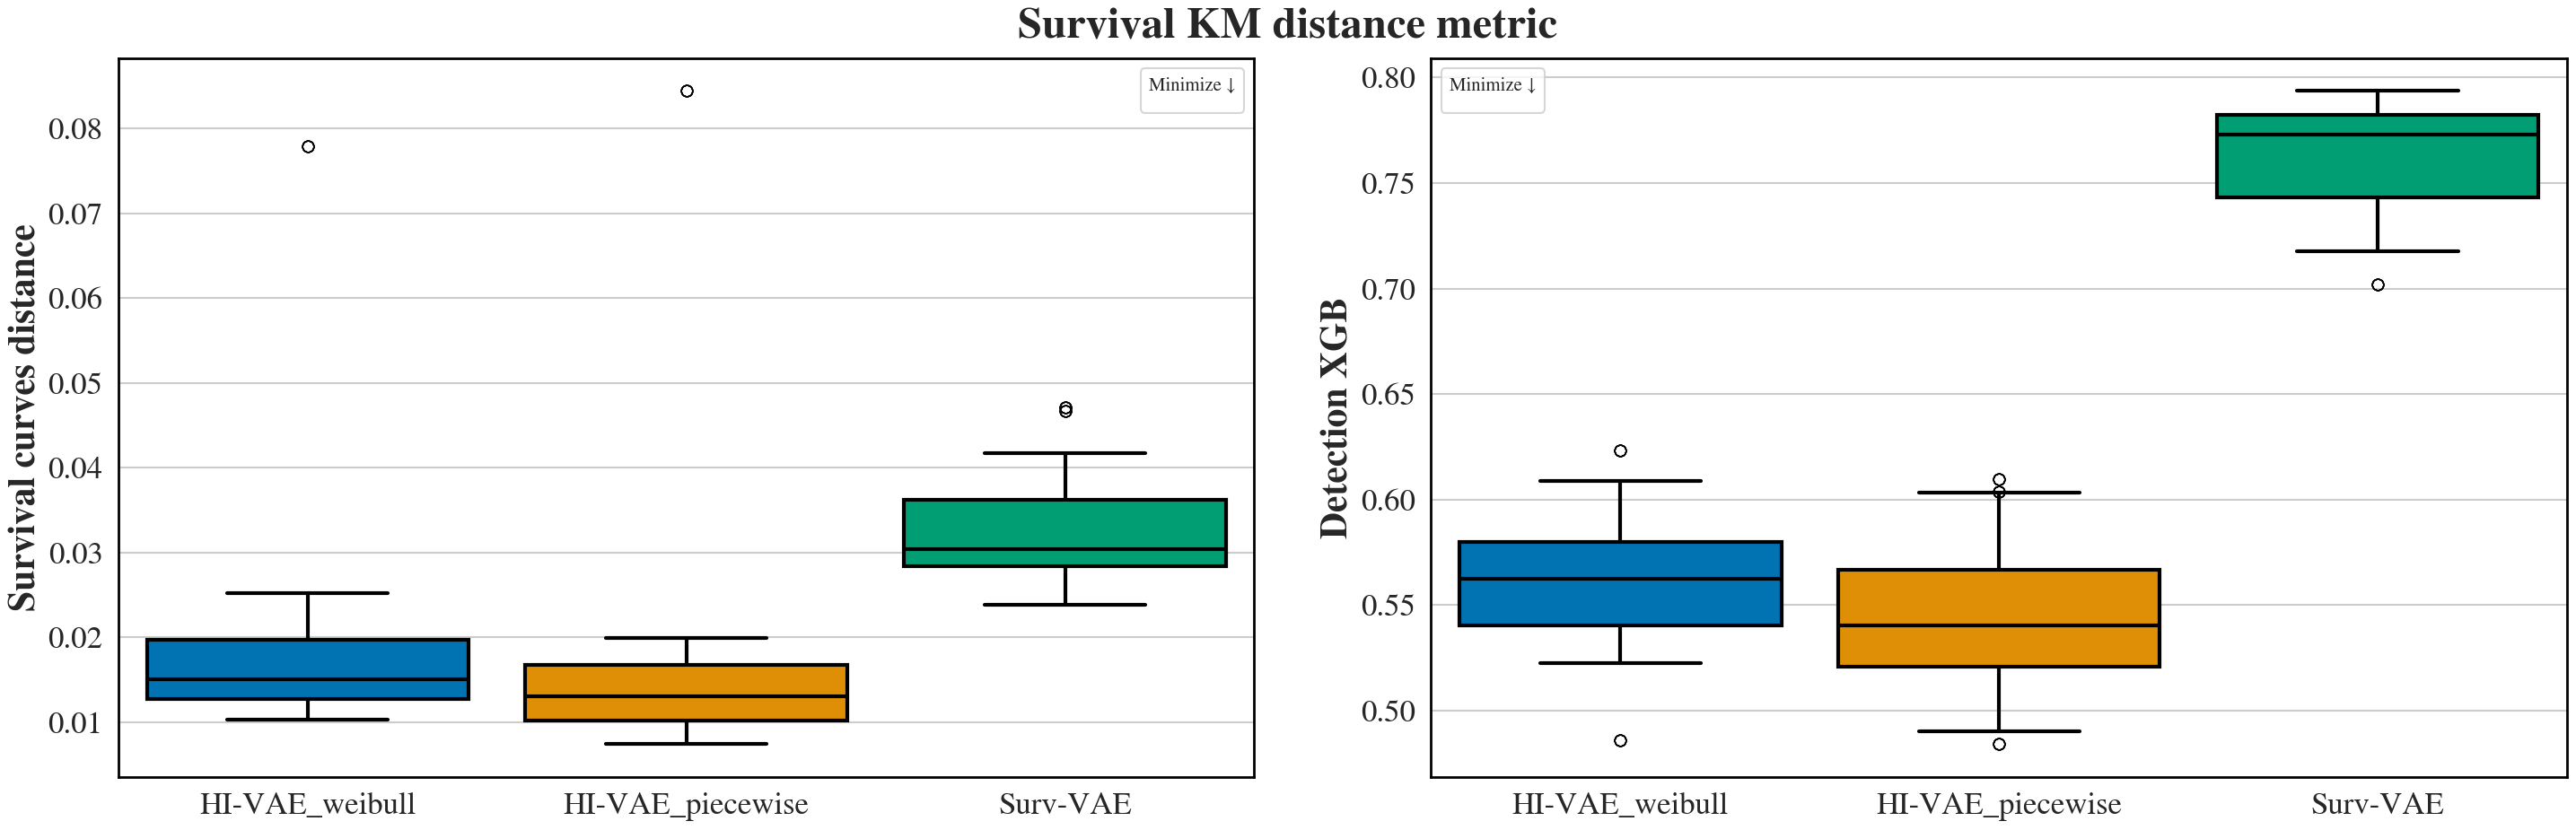

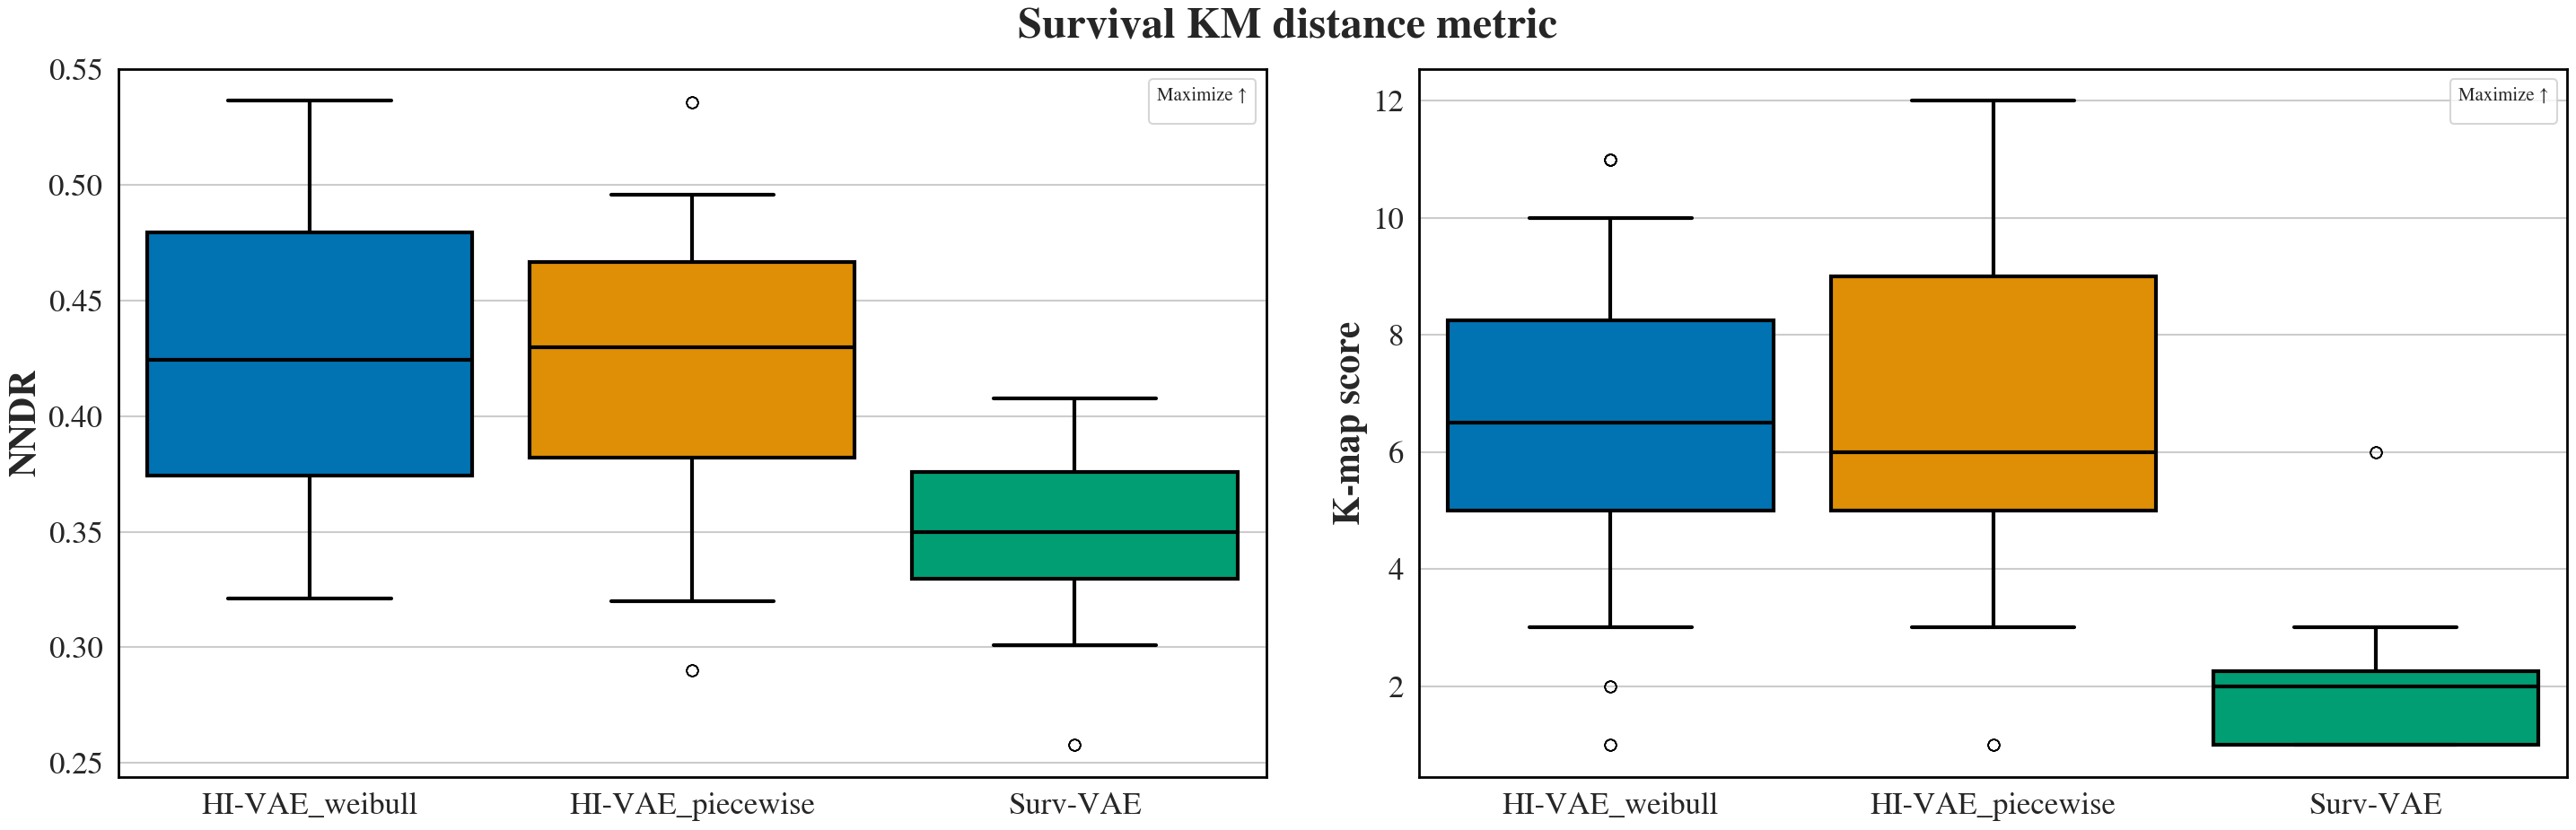

In [13]:
for metrics in [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]:
    visualize_synthcity_metric_res_ext(results_kmdist, metrics, 'Survival KM distance metric')

In [14]:
n_MC_exp = 5
from utils.metrics import estimate_agreement, decision_agreement, standardized_difference, ci_overlap
columns = ['time', 'censor', 'treatment']

# score_df = pd.DataFrame(columns=["Generator", "Treatment_effect", "MC_exp", "Nb generated datasets", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
score_df = pd.DataFrame(columns=["Generator", "Treatment effect", "Estimate agreement", "Decision agreement", "Standardized difference", "CI overlap"])
for treatment_effect in treat_effects:
    results_treat = results_kmdist_ext[results_kmdist_ext.H0_coef == treatment_effect]
    cox_init = results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values
    for m in range(n_MC_exp):
        results_MC = results_treat[(results_treat[["est_cox_coef_init", "est_cox_coef_se_init"]] == cox_init[m]).all(axis=1)]
        coef_init, se_init = results_MC[["est_cox_coef_init", "est_cox_coef_se_init"]].drop_duplicates().values[0]
        ci_init = (coef_init - 1.96 * se_init, coef_init + 1.96 * se_init)

        for generator in generators_sel:
            best_metric = np.min(results_MC["Survival curves distance_" + generator].values)
            results_MC_best = results_MC[results_MC["Survival curves distance_" + generator] == best_metric]
            coef_syn, se_syn = results_MC_best[["est_cox_coef_" + generator, "est_cox_coef_se_" + generator]].values.flatten()
            ci_syn = (coef_syn - 1.96 * se_syn, coef_syn + 1.96 * se_syn)

            res = [estimate_agreement(ci_init, coef_syn),
                decision_agreement(coef_init, ci_init, coef_syn, ci_syn),
                standardized_difference(coef_init, coef_syn, se_init),
                ci_overlap(ci_init, ci_syn)]

            # score_df.loc[len(score_df)] = [generator, treatment_effect, m, j] + res
            score_df.loc[len(score_df)] = [generator, treatment_effect] + res

score_df = score_df.groupby(["Generator", "Treatment effect"]).mean().reset_index()

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [15]:
def visualize_replicability_te_perf(scores):
    """
    Generate boxplots to visualize performance scores across different generators.

    Args:
        scores (DataFrame): Performance metrics for different synthetic data generators.
    """
    metric_names = scores.columns.values[2:]
    num_metrics = len(metric_names)
    fig, axs = plt.subplots(1, num_metrics, figsize=(6 * num_metrics, 6))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, ax in enumerate(axs):
        # Format axis spines
        metric_name = metric_names[i]
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.lineplot(data=scores, x='Treatment effect', y=metric_name,
                     hue="Generator", ax=ax, palette = 'colorblind')
        ax.set_xlabel('Treatment effect', fontsize=20, fontweight="semibold")
        ax.set_ylabel(metric_name, fontsize=20, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        ax.set_ylim(0, 1.05)
    plt.tight_layout(pad=3)
    plt.show()

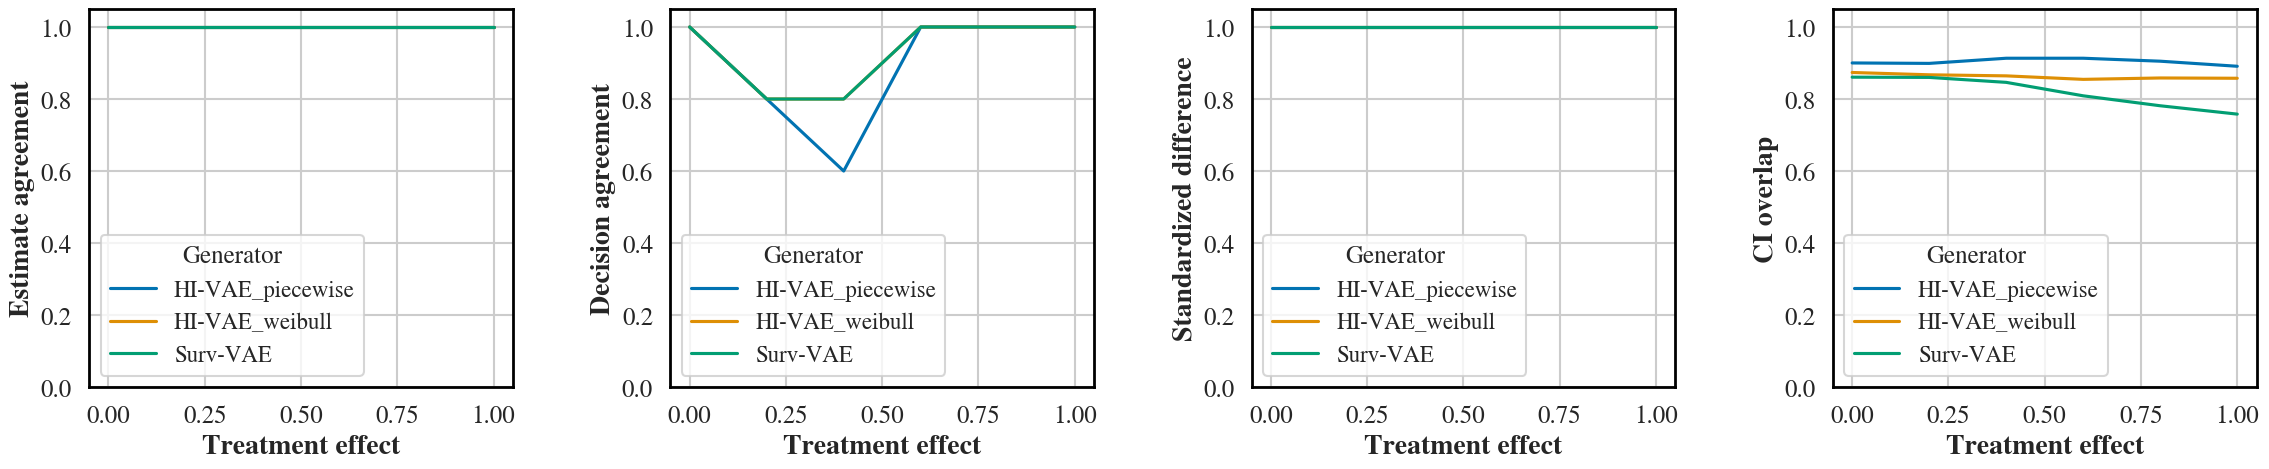

In [16]:
visualize_replicability_te_perf(score_df)

In [17]:
metric_control_df = pd.DataFrame()
for generator_name in generators_sel:
    metric_control_df = pd.concat([metric_control_df, pd.DataFrame(np.array([[generator_name] * results_kmdist_ext.shape[0], 
                                                            results_kmdist_ext["log_pvalue_control_" + generator_name]]).T,
                                                            columns=['generator', 'log_pvalue'])])

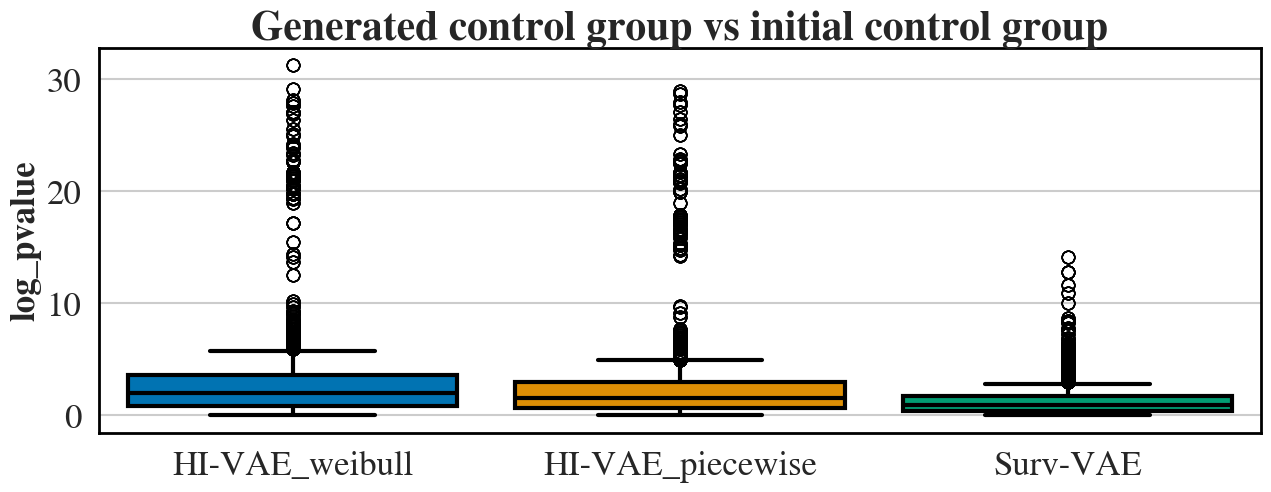

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

metric_control_df['log_pvalue'] = np.float64(metric_control_df['log_pvalue'].values)
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_edgecolor('black')

sns.boxplot(data=metric_control_df, x='generator', y='log_pvalue', ax=ax,
            linewidth = 3, saturation = 1, palette = 'colorblind', 
            width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
ax.set_xlabel('')
ax.set_ylabel('log_pvalue', fontsize=25, fontweight="semibold")
ax.set_title('Generated control group vs initial control group', fontsize=30, fontweight="semibold")
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)